# Test `MegaScreen()` against Winker 1991

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MegaScreen
from zernike import ZernikeGrid, jtonm
from theory import winker_variance_quad, winker_piston_residual

In [2]:
def simulate_winker_fig2(
    diameter=100, L0Min=16, L0Max=8000, numL0=20, numIter=100, maxRadial=2
):
    """Derive simulated data corresponding to Figure 2 of Winker 1991"""
    zernike = ZernikeGrid(diameter, maxRadial=maxRadial)
    L0s = np.logspace(np.log10(L0Min), np.log10(L0Max), numL0)
    result = []
    for L0 in L0s:
        variance = np.zeros(len(zernike))
        for screen in MegaScreen.MegaScreen(
            r0=float(diameter),
            L0=L0,
            windowShape=[diameter, diameter],
            dx=diameter,
            numIter=numIter,
        ):
            variance += residual_variance(screen, zernike)
        result.append(variance / numIter)
    return L0s, np.array(result).transpose()


def residual_variance(screen, zernike):
    """ Return variance of a phase screen as increasing
    numbers of Zernikes are removed"""
    screen = screen * zernike[0]  # Cut out a circle
    normalisation = np.sum(zernike[0])
    result = np.zeros(len(zernike))
    for i in range(len(zernike)):
        screen = screen - zernike[i] * np.sum(zernike[i] * screen) / normalisation
        result[i] = np.sum(screen ** 2) / normalisation
    return result

In [5]:
# Run the simulation - may take a few minutes
diameter = 100
L0s, variances = simulate_winker_fig2(diameter=diameter, numIter=1000)

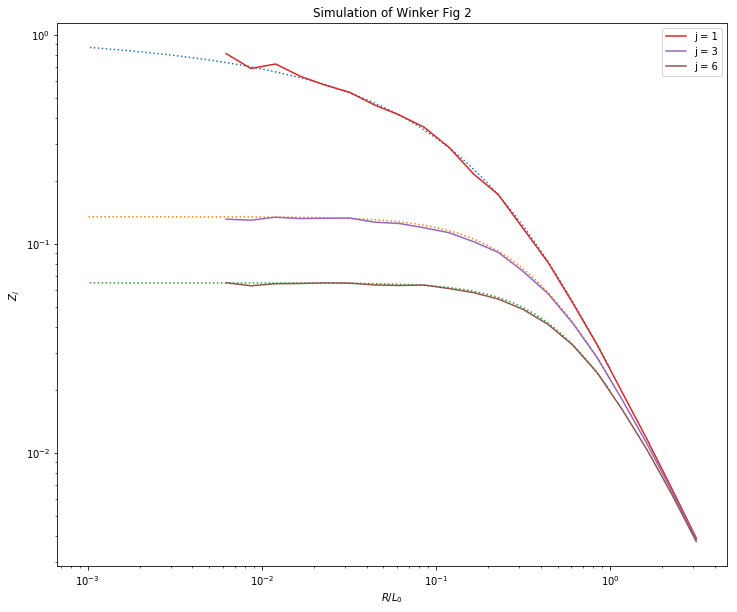

In [6]:
def plot_simulation(L0s, variances, diameter):
    L0 = 2 * L0s / diameter
    for z in [0, 2, 5]:
        plt.loglog(1 / L0, variances[z], label="j = " + str(z + 1))
    plt.legend()


def plot_theory(L0=np.logspace(0, 3, 50), max_n=2):
    resid = np.empty((max_n + 1, len(L0)))
    for i in range(len(L0)):
        L = L0[i]
        resid[0, i] = winker_piston_residual(L0=L)
        for n in range(1, max_n + 1):
            resid[n, i] = resid[n - 1, i] - winker_variance_quad(n, R=1, r0=2, L0=L) * (
                n + 1
            )
    for n in range(len(resid)):
        plt.loglog(1 / (L0), resid[n], ls="dotted")


plt.figure(figsize=(12, 10))
plt.xlabel(r"$R/L_0$")
plt.ylabel("$Z_j$")
plt.title("Simulation of Winker Fig 2")
plot_theory()
plot_simulation(L0s, variances, diameter)